In [1]:
import TensorFlow
import Python

In [2]:
%include "PythonCheckpointReader.swift"

In [3]:
let reader = PythonCheckpointReader(path: "./vgg_16.ckpt")

In [4]:
let weightTensor = reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_1/weights")

Name: vgg_16/conv1/conv1_1/weights


In [5]:
let biasTensor = reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_1/biases")

Name: vgg_16/conv1/conv1_1/biases


In [6]:
let fc6Weights = reader.readTensor(layerName: "vgg_16/fc6", weightName: "weights")

Name: vgg_16/fc6/weights


In [7]:
print(weightTensor!.shape)
print(biasTensor!.shape)
print(fc6Weights!.shape)

TensorShape(dimensions: [3, 3, 3, 64])
TensorShape(dimensions: [64])
TensorShape(dimensions: [7, 7, 512, 4096])


In [8]:
// let np = Python.import("numpy")

In [9]:
// var weights = np.load("./vgg16_weights.npz")
// let keys = Python.sorted(weights.keys())

In [10]:
// print(type(of: weights))

In [11]:
// for key in keys {
//     print(weights[key].shape)
// }

In [12]:
// let test = Tensor<Float>(numpy: weights["conv1_1_W"])!
// print(type(of: test))

In [13]:
public protocol FALayer: Layer {
    associatedtype Input
    associatedtype Output
    
    var delegate: LayerDelegate<Output> { get set }
    
    @differentiable
    func forward(_ input: Input) -> Output
    
}

public extension FALayer {
    
    @differentiable
    func applied(to input: Input, in context: Context) -> Output {
        let activation = forward(input)
        delegate.didProduceActivation(activation)
        return activation
    }
    
    @differentiable
    func call(_ input: Input) -> Output {
        let activation = forward(input)
        delegate.didProduceActivation(activation)
        return activation
    }
}

open class LayerDelegate<Output> {
    var lastActivation: Output?
    public init() {}
    
    open func didProduceActivation(_ activation: Output) {}
}

In [14]:
@_fixed_layout
public struct FAConv2D<Scalar: TensorFlowFloatingPoint>: FALayer {
    public typealias Input = Tensor<Scalar>
    public typealias Output = Tensor<Scalar>
    
    public var filter: Tensor<Scalar>
    public var bias: Tensor<Scalar>
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    @noDerivative public let activation: Activation
    @noDerivative public let strides: (Int32, Int32)
    @noDerivative public let padding: Padding
    
    @noDerivative public var delegate: LayerDelegate<Output> = LayerDelegate()

    public init(
        filter: Tensor<Scalar>,
        bias: Tensor<Scalar>,
        activation: @escaping Activation,
        strides: (Int32, Int32),
        padding: Padding
    ) {
        self.filter = filter
        self.bias = bias
        self.activation = activation
        self.strides = strides
        self.padding = padding
    }

    @differentiable
    public func forward(_ input: Tensor<Scalar>) -> Tensor<Scalar> {
        return activation(input.convolved2D(withFilter: filter,
                                            strides: (1, strides.0, strides.1, 1),
                                            padding: padding) + bias)
    }
}

public extension FAConv2D {
    init<G: RandomNumberGenerator>(
        filterShape: (Int32, Int32, Int32, Int32),
        strides: (Int32, Int32) = (1, 1),
        padding: Padding = .valid,
        activation: @escaping Activation = identity,
        generator: inout G
    ) {
        let filterTensorShape = TensorShape([
            filterShape.0, filterShape.1,
            filterShape.2, filterShape.3])
        self.init(
            filter: Tensor(glorotUniform: filterTensorShape, generator: &generator),
            bias: Tensor(zeros: TensorShape([filterShape.3])),
            activation: activation,
            strides: strides,
            padding: padding)
    }
}

public extension FAConv2D {
    init(
        filterShape: (Int32, Int32, Int32, Int32),
        strides: (Int32, Int32) = (1, 1),
        padding: Padding = .valid,
        activation: @escaping Activation = identity,
        seed: (Int64, Int64) = (Int64.random(in: Int64.min..<Int64.max),
                                Int64.random(in: Int64.min..<Int64.max))
    ) {
        let filterTensorShape = TensorShape([
            filterShape.0, filterShape.1,
            filterShape.2, filterShape.3])
        self.init(
            filter: Tensor(glorotUniform: filterTensorShape, seed: seed),
            bias: Tensor(zeros: TensorShape([filterShape.3])),
            activation: activation,
            strides: (strides.0, strides.1),
            padding: padding)
    }
}

In [32]:
struct VGG16: Layer {
    
    var conv1a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 3, 64), strides: (1, 1), padding: .same)
    var conv1b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 64, 64), strides: (1, 1), padding: .same)
    
    var conv2a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 64, 128), strides: (1, 1), padding: .same)
    var conv2b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 128, 128), strides: (1, 1), padding: .same)
    
    var conv3a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 128, 256), strides: (1, 1), padding: .same)
    var conv3b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 256, 256), strides: (1, 1), padding: .same)
    var conv3c: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 256, 256), strides: (1, 1), padding: .same)
    
    var conv4a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 256, 512), strides: (1, 1), padding: .same)
    var conv4b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
    var conv4c: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
    
    var conv5a: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
    var conv5b: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
    var conv5c: FAConv2D<Float>// = Conv2D<Float>(filterShape: (3, 3, 512, 512), strides: (1, 1), padding: .same)
        
    var maxPool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool3 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool4 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    var maxPool5 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2), padding: .same)
    
//     var flatten = Flatten<Float>()
    
//     var fc1: Dense<Float>
//     var fc2: Dense<Float>
//     var fc3: Dense<Float>
    
    init(reader: PythonCheckpointReader, layerDelegates: [String: LayerDelegate<Tensor<Float>>]) {
        
        let strides = (Int32(1), Int32(1))
        self.conv1a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv1a"] {
            print(delegate)
            self.conv1a.delegate = delegate
        }
        
        self.conv1b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv1", weightName: "conv1_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same).withoutDerivative()
        
// Layer 2
        self.conv2a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv2", weightName: "conv2_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv2", weightName: "conv2_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv2a"] {
            print(delegate)
            self.conv2a.delegate = delegate
        }
        self.conv2b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv2", weightName: "conv2_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv2", weightName: "conv2_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
// Layer 3
        self.conv3a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv3a"] {
            print(delegate)
            self.conv3a.delegate = delegate
        }
        
        self.conv3b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        self.conv3c = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_3/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv3", weightName: "conv3_3/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
// Layer 4
        self.conv4a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv4a"] {
            print(delegate)
            self.conv4a.delegate = delegate
        }
        
        self.conv4b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv4b"] {
            print(delegate)
            self.conv4b.delegate = delegate
        }
        
        self.conv4c = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_3/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv4", weightName: "conv4_3/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
// Layer 5
        
        self.conv5a = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_1/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_1/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        if let delegate = layerDelegates["conv5a"] {
            print(delegate)
            self.conv5a.delegate = delegate
        }
        
        self.conv5b = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_2/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_2/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
        
        self.conv5c = FAConv2D(filter: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_3/weights")!, 
                             bias: reader.readTensor(layerName: "vgg_16/conv5", weightName: "conv5_3/biases")!, 
                             activation: relu,
                             strides: strides,
                             padding: .same)
    }
    
//     typealias Output = Tensor<Float>
    @differentiable
    func applied(to input: Tensor<Float>, in context: Context) -> Tensor<Float> {
//         var activations = [String: Tensor<Float>]()
        var tmp = input
        
        // Layer 1
        tmp = conv1a.applied(to: tmp, in: context)
        tmp = conv1b.applied(to: tmp, in: context)
        tmp = maxPool1.applied(to: tmp, in: context)
        
        // Layer 2 
        tmp = conv2a.applied(to: tmp, in: context)
        tmp = conv2b.applied(to: tmp, in: context)
        tmp = maxPool2.applied(to: tmp, in: context)
        
        // Layer 3
        tmp = conv3a.applied(to: tmp, in: context)
        tmp = conv3b.applied(to: tmp, in: context)
        tmp = conv3c.applied(to: tmp, in: context)
        tmp = maxPool3.applied(to: tmp, in: context)
        
        // Layer 4
        tmp = conv4a.applied(to: tmp, in: context)
        tmp = conv4b.applied(to: tmp, in: context)
        tmp = conv4c.applied(to: tmp, in: context)
        tmp = maxPool4.applied(to:  tmp, in: context)
        
        // Layer 5
        tmp = conv5a.applied(to: tmp, in: context)
        tmp = conv5b.applied(to: tmp, in: context)
        tmp = conv5c.applied(to: tmp, in: context)
        tmp = maxPool5.applied(to: tmp, in: context)
        
        return tmp
    }
}

In [54]:
class Conv1aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
        print("1a shape: \(activation.shape)")
    }
}

class Conv2aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
        print("2a shape: \(activation.shape)")
    }
}

class Conv3aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
        print("3a shape: \(activation.shape)")
    }
}

class Conv4aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
        print("4a shape: \(activation.shape)")
    }
}

class Conv4bDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
        print("4b shape: \(activation.shape)")
    }
}

class Conv5aDelegate: LayerDelegate<Tensor<Float>> {
    override func didProduceActivation(_ activation: Tensor<Float>) {
        self.lastActivation = activation
        print("5a shape: \(activation.shape)")
    }
}

let conv1aDelegate = Conv1aDelegate()
let conv2aDelegate = Conv2aDelegate()
let conv3aDelegate = Conv3aDelegate()
let conv4aDelegate = Conv4aDelegate()
let conv4bDelegate = Conv4bDelegate()
let conv5aDelegate = Conv5aDelegate()

let delegates = ["conv1a" : conv1aDelegate,
                 "conv2a" : conv2aDelegate,
                 "conv3a" : conv3aDelegate,
                 "conv4a" : conv4aDelegate,
                 "conv4b" : conv4bDelegate,
                 "conv5a" : conv5aDelegate]

var model = VGG16(reader: reader, layerDelegates: delegates)

Name: vgg_16/conv1/conv1_1/weights
Name: vgg_16/conv1/conv1_1/biases
__lldb_expr_375.Conv1aDelegate
Name: vgg_16/conv1/conv1_2/weights
Name: vgg_16/conv1/conv1_2/biases
Name: vgg_16/conv2/conv2_1/weights
Name: vgg_16/conv2/conv2_1/biases
__lldb_expr_375.Conv2aDelegate
Name: vgg_16/conv2/conv2_2/weights
Name: vgg_16/conv2/conv2_2/biases
Name: vgg_16/conv3/conv3_1/weights
Name: vgg_16/conv3/conv3_1/biases
__lldb_expr_375.Conv3aDelegate
Name: vgg_16/conv3/conv3_2/weights
Name: vgg_16/conv3/conv3_2/biases
Name: vgg_16/conv3/conv3_3/weights
Name: vgg_16/conv3/conv3_3/biases
Name: vgg_16/conv4/conv4_1/weights
Name: vgg_16/conv4/conv4_1/biases
__lldb_expr_375.Conv4aDelegate
Name: vgg_16/conv4/conv4_2/weights
Name: vgg_16/conv4/conv4_2/biases
__lldb_expr_375.Conv4bDelegate
Name: vgg_16/conv4/conv4_3/weights
Name: vgg_16/conv4/conv4_3/biases
Name: vgg_16/conv5/conv5_1/weights
Name: vgg_16/conv5/conv5_1/biases
__lldb_expr_375.Conv5aDelegate
Name: vgg_16/conv5/conv5_2/weights
Name: vgg_16/conv5/c

In [55]:
// print(model.conv1a.filter.shape)
// print(model.conv1b.filter.shape)

// print(model.conv2a.filter.shape)
// print(model.conv2b.filter.shape)

// print(model.conv3a.filter.shape)
// print(model.conv3b.filter.shape)
// print(model.conv3c.filter.shape)

// print(model.conv4a.filter.shape)
// print(model.conv4b.filter.shape)
// print(model.conv4c.filter.shape)

// print(model.conv5a.filter.shape)
// print(model.conv5b.filter.shape)
// print(model.conv5c.filter.shape)

// print(model.fc1.weight.shape)
// print(model.fc2.weight.shape)
// print(model.fc3.weight.shape)

In [56]:
// print(model.fc3.weight)

In [57]:
let Image = Python.import("PIL.Image")

In [58]:
let np = Python.import("numpy")

In [59]:
func resizeImage(filename: StringTensor, size: (Int32, Int32)) -> Tensor<Float> {
    let imageBytes: StringTensor = Raw.readFile(filename: filename)
    let decodedImage = Raw.decodeJpeg(contents: imageBytes, channels: 3, dctMethod: "") 
    let resizedImages = Raw.resizeBicubic(
        images: Tensor<UInt8>([decodedImage]), 
        size: Tensor<Int32>([size.0, size.1]))
    return resizedImages.reshaped(to: TensorShape(size.0, size.1, 3))
}

In [60]:
let testImageTensor = resizeImage(filename: StringTensor("./puppy.jpg"), size: (224, 224))
let testStyleTensor = resizeImage(filename: StringTensor("./strokes.jpg"), size: (224, 224))

In [61]:
// Setup.
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


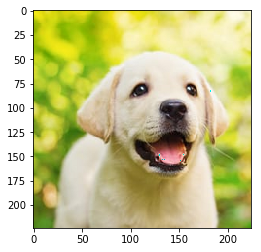

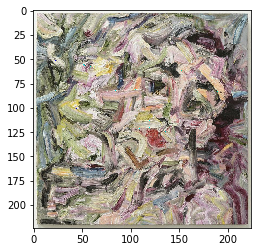

None


In [62]:
plt.imshow(Tensor<UInt8>(testImageTensor).makeNumpyArray())
plt.show()
plt.imshow(Tensor<UInt8>(testStyleTensor).makeNumpyArray())
plt.show()

In [63]:
// TF Format: NHWC
// PIL Format: WHC
let mean = Tensor<Float>([103.939, 116.78, 123.68])
let std  = Tensor<Float>([0.229, 0.224, 0.225])
let normalizedImage = ((testImageTensor) - mean)
let normalizedStyle = ((testStyleTensor) - mean)
let testImageBatch = normalizedImage.expandingShape(at: 0)
let testStyleBatch = normalizedImage.expandingShape(at: 0)

In [64]:
print(testImageBatch.shape)

TensorShape(dimensions: [1, 224, 224, 3])


In [65]:
let context = Context(learningPhase: .inference)
let logits = model.applied(to: testImageBatch, in: context)

1a shape: TensorShape(dimensions: [1, 224, 224, 64])
2a shape: TensorShape(dimensions: [1, 112, 112, 128])
3a shape: TensorShape(dimensions: [1, 56, 56, 256])
4a shape: TensorShape(dimensions: [1, 28, 28, 512])
4b shape: TensorShape(dimensions: [1, 28, 28, 512])
5a shape: TensorShape(dimensions: [1, 14, 14, 512])


In [ ]:
// [[[[          0.0,      90.09491,    0.16655076, ...,           0.0,     10.285216,

In [91]:
var act = model.conv1a.delegate.lastActivation!
print(act.shape)
print(act)

TensorShape(dimensions: [1, 224, 224, 64])
[[[[          0.0,           0.0,     0.3344079, ...,           0.0,      8.643557,
              0.0],
   [          0.0,           0.0,      44.44159, ...,           0.0,      135.0284,
        81.990005],
   [          0.0,           0.0,      45.36498, ...,           0.0,     136.64584,
         83.87394],
   ...,
   [          0.0,           0.0,     70.833275, ...,           0.0,     271.28036,
        144.59192],
   [          0.0,           0.0,      71.26074, ...,           0.0,     275.23807,
         145.7809],
   [     5.565851,           0.0,      153.1784, ...,           0.0,     451.91113,
        348.03354]],

  [[          0.0,           0.0,           0.0, ...,           0.0,           0.0,
              0.0],
   [          0.0,           0.0,       43.4188, ...,           0.0,           0.0,
          24.2336],
   [  0.008585513,           0.0,      44.51278, ...,           0.0,           0.0,
         26.46695],
   ...,
   

In [117]:
let reshaped = act.reshaped(to: TensorShape(act.shape[0], 
                                                         act.shape[1] * act.shape[2], 
                                                         act.shape[3])).squeezingShape(at: 0)
print(reshaped.shape)
print(reshaped.transposed().shape)
print(( reshaped.transposed() • reshaped ).shape)

TensorShape(dimensions: [50176, 64])
TensorShape(dimensions: [64, 50176])
TensorShape(dimensions: [64, 64])


In [118]:
func gramProduct(of tensor: Tensor<Float>) -> Tensor<Float> {
    let flatActivation = tensor.reshaped(to: TensorShape(tensor.shape[0], 
                                                         tensor.shape[1] * tensor.shape[2], 
                                                         tensor.shape[3])).squeezingShape(at: 0)
    
    let actTransposed = flatActivation.transposed()
    
    print("act: \(flatActivation.shape) act.t: \(actTransposed.shape)")
    var gram = actTransposed • flatActivation
    gram =  gram / Float(tensor.shape[1] * tensor.shape[2])
    return gram
}

In [120]:
let actGram = gramProduct(of: act)

act: TensorShape(dimensions: [50176, 64]) act.t: TensorShape(dimensions: [64, 50176])


In [123]:
print(actGram)

[[    1326.5538,    0.09549093,      628.0849, ...,     315.78033,      550.5934,
       764.9562],
 [   0.09549093,   0.017772509,    0.07796878, ...,           0.0,    0.20676465,
     0.16820839],
 [     628.0849,    0.07796878,     1399.1676, ...,      91.95782,     557.53094,
      851.33105],
 ...,
 [    315.78033,           0.0,      91.95782, ...,     2500.6707,     268.69855,
      208.68738],
 [     550.5934,    0.20676465,     557.53094, ...,     268.69855,     1101.3185,
       890.8391],
 [     764.9562,    0.16820839,     851.33105, ...,     208.68738,      890.8391,
      961.60986]]


In [95]:
let prod = act.product()